In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import zeroPadding

import time
start_time = time.time()

In [2]:
dataset_path = r"C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i>10:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM06.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM07.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM08.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM09.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hy

In [3]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 5000

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [4]:
class VGG16_HSI(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16_HSI, self).__init__()

         # Custom Convolutional Layer: Process 9x9x224 input
        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels=224, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (256, 1, 1)
        )

        # Fully Connected Layer to reshape to (64, 56, 56)
        self.fc = nn.Linear(256 * 1 * 1, 64 * 56 * 56)

        # Load VGG-16 Model
        self.encoder = vgg16(pretrained=False)

        # Remove first VGG-16 conv layer
        self.encoder.features = nn.Sequential(*list(self.encoder.features.children())[1:])

        # Modify classifier to output 2 classes
        self.encoder.classifier[6] = nn.Linear(4096, 2)

    def forward(self, x):
        # print(f'before {x.shape}')
        x = self.pre_conv(x)  # Process hyperspectral input
        x = x.view(x.size(0), -1)  # Flatten

        # print(f'after preconv {x.shape}')
        x = self.fc(x)  # Fully connected layer
        # print(f'after fc {x.shape}')
        # Reshape to (batch_size, 64, 56, 56) before passing to VGG
        x = x.view(x.size(0), 64, 56, 56)
        # print(f'after reshape, before vgg second layer {x.shape}')

        x = self.encoder.features(x)  # Pass to VGG-16
        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.encoder.classifier(x)  # Final classification layer

        return x

In [5]:
def predict_batch(model, batch_input, device):
    model.eval()
    batch_input = batch_input.to(device)

    with torch.no_grad():
        output = model(batch_input)
        # Apply softmax to get class probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1)

        # Get predicted class (0 or 1)
        predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Get probability of class 1 (positive class) — required for ROC
        positive_class_probs = probabilities[:, 1].cpu().numpy()

    

    return predicted_classes, positive_class_probs


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64  # You can change this depending on your GPU capacity

model_path = r"C:\Users\Asus TUF\Documents\code\TA\simsiam\simsiam\models\finetune\20250603_102842_model.pth.tar"
model_name = model_path.split('\\')[-1]

print(f"Creating model {model_name}...")
saved_model = VGG16_HSI().to(device)
checkpoint = torch.load(model_path, map_location=device)
saved_model.load_state_dict(checkpoint['state_dict'])
print("Model loaded and moved to device")

Creating model 20250603_102842_model.pth.tar...


c:\Users\Asus TUF\Documents\code\TA\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus TUF\Documents\code\TA\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Asus TUF\AppData\Local\Temp\ipykernel_13900\4039813665.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default va

Model loaded and moved to device


In [7]:


patch_size = 9
half_patch = patch_size // 2

scores = []

groundtruth = []
prediction = []
y_probs = []


for dataset in range(len(datasets)):
    print(f"tes: {dataset}")
    test_indices, test_gt, matrix = testWithDataset(dataset)

    total = len(test_indices)
    correct0 = 0
    correct1 = 0

    input_patches = []
    true_labels = []

    # Prepare all patches
    for x_pos, y_pos in test_indices:
        true_label = test_gt[x_pos][y_pos]

        selected_rows = matrix[x_pos:x_pos + 2*half_patch + 1, :]
        testing_patch = selected_rows[:, y_pos:y_pos + 2*half_patch + 1]

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.unsqueeze(0).permute(0, 3, 1, 2)

        input_patches.append(patch_tensor)
        true_labels.append(true_label)

    input_patches = torch.cat(input_patches, dim=0)  # Shape: (N, C, H, W)
    true_labels = torch.tensor(true_labels)

    # Process in batches
    for i in tqdm(range(0, total, batch_size), desc="Predicting"):
        batch = input_patches[i:i+batch_size]
        labels = true_labels[i:i+batch_size]

        groundtruth.append(labels)

        preds, postive_class_probs = predict_batch(saved_model, batch, device)

        prediction.append(preds)
        y_probs.append(postive_class_probs)

        for j in range(len(preds)):
            index = i + j
            # print(f"{index+1}: prediction = {preds[j]}, confidence: {confs[j]:.4f}, expected: {labels[j].item()}")
            if preds[j] == labels[j].item():
                if labels[j].item() == 0:
                    correct0 += 1
                elif labels[j] == 1:
                    correct1 += 1

    correct = correct0 + correct1
    print(f"Score: {correct}/{total}")
    
    score = {
        'dataset': dataset,
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    scores.append(score)
    # scores.append((f"dataset{dataset}", f'{correct0}/{total/2}', f'{correct1}/{total/2}', f'{correct}/{total}'))

tes: 0
img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s]


Score: 8755/10000
tes: 1
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 15.08it/s]


Score: 5885/10000
tes: 2
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 15.12it/s]


Score: 9072/10000
tes: 3
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 14.63it/s]


Score: 9369/10000
tes: 4
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 14.38it/s]


Score: 9169/10000
tes: 5
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 14.96it/s]


Score: 9130/10000
tes: 6
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 14.77it/s]


Score: 5037/10000
tes: 7
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 14.78it/s]


Score: 5036/10000
tes: 8
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 15.12it/s]


Score: 5001/10000
tes: 9
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 14.39it/s]


Score: 8475/10000
tes: 10
img shape: (1185, 682, 224)
img shape after padding (1193, 690, 224)
number of pixel 808170
ground truth shape: (1185, 682)
indices = 0 shape: (770065, 2)
indices = 1 shape: (38105, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:10<00:00, 15.25it/s]

Score: 8509/10000


In [8]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{total/2}\t', f'{correct1}/{total/2}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1


print(f"total: \t\t {all_correct0}/{all_total/2} \t {all_correct1}/{all_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

dataset: 0	 4701/5000.0	 4054/5000.0	 8755/10000	
dataset: 1	 992/5000.0	 4893/5000.0	 5885/10000	
dataset: 2	 4104/5000.0	 4968/5000.0	 9072/10000	
dataset: 3	 4452/5000.0	 4917/5000.0	 9369/10000	
dataset: 4	 4305/5000.0	 4864/5000.0	 9169/10000	
dataset: 5	 4567/5000.0	 4563/5000.0	 9130/10000	
dataset: 6	 5000/5000.0	 37/5000.0	 5037/10000	
dataset: 7	 5000/5000.0	 36/5000.0	 5036/10000	
dataset: 8	 4991/5000.0	 10/5000.0	 5001/10000	
dataset: 9	 3780/5000.0	 4695/5000.0	 8475/10000	
dataset: 10	 3676/5000.0	 4833/5000.0	 8509/10000	
total: 		 45568/55000.0 	 37870/55000.0 	 83438/110000
acc: 0.7585272727272727


In [9]:
groundtruths = groundtruth
groundtruth = []

for x in groundtruths:
    for y in x:
        groundtruth.append(y)

predictions = prediction
prediction = []

for x in predictions:
    for y in x:
        prediction.append(y)


y_prob = []

for x in y_probs:
    for y in x:
        y_prob.append(y)

In [10]:
print(len(groundtruth))
print(len(prediction))
print(len(y_prob))

110000
110000
110000


In [11]:
y_test = groundtruth
y_pred = prediction
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

In [12]:
print(f'{correct}/{total}')

83438/110000


In [13]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


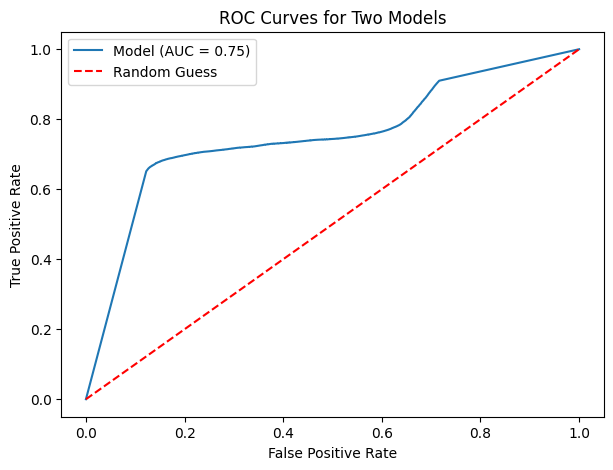

In [14]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [15]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction                          # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.7637
Recall:    0.7585
F1 Score:  0.7573
OA:        0.7585
AA:        0.7585


In [16]:

performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [17]:
import json

print(result_json)

with open(f"performance/{model_name}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'correct_0': 4701, 'correct_1': 4054, 'correct_total': 8755, 'total': 10000}, {'dataset': 1, 'correct_0': 992, 'correct_1': 4893, 'correct_total': 5885, 'total': 10000}, {'dataset': 2, 'correct_0': 4104, 'correct_1': 4968, 'correct_total': 9072, 'total': 10000}, {'dataset': 3, 'correct_0': 4452, 'correct_1': 4917, 'correct_total': 9369, 'total': 10000}, {'dataset': 4, 'correct_0': 4305, 'correct_1': 4864, 'correct_total': 9169, 'total': 10000}, {'dataset': 5, 'correct_0': 4567, 'correct_1': 4563, 'correct_total': 9130, 'total': 10000}, {'dataset': 6, 'correct_0': 5000, 'correct_1': 37, 'correct_total': 5037, 'total': 10000}, {'dataset': 7, 'correct_0': 5000, 'correct_1': 36, 'correct_total': 5036, 'total': 10000}, {'dataset': 8, 'correct_0': 4991, 'correct_1': 10, 'correct_total': 5001, 'total': 10000}, {'dataset': 9, 'correct_0': 3780, 'correct_1': 4695, 'correct_total': 8475, 'total': 10000}, {'dataset': 10, 'correct_0': 3676, 'correct_1': 4833, 'correc

In [18]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

Run time: 198.9313 seconds
